#  Прогнозирование заказов такси

Агрегатор такси собрал исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

## Подготовка данных

In [26]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot  as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from statsmodels.regression import linear_model
from patsy import dmatrices
from sklearn.ensemble import RandomForestRegressor
import statsmodels.graphics.tsaplots as tsa
from statsmodels.tsa.arima.model import ARIMA as ARIMA
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from lightgbm import LGBMRegressor

In [27]:
warnings.filterwarnings('ignore')
sns.set()

In [28]:
df = pd.read_csv('datasets/taxi.csv',
                 index_col=[0],
                 parse_dates=[0])
print(df.index.is_monotonic)

True


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [31]:
df.index.duplicated().sum()

0

In [32]:
df['rolling'] = df.rolling(6).mean()

<AxesSubplot:xlabel='datetime'>

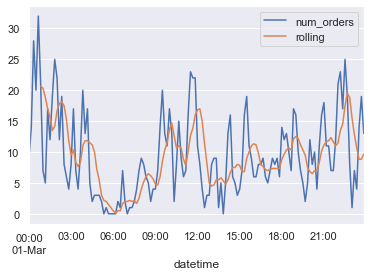

In [33]:
df[:24*6].plot()

*В данных нет пропусков и дубликатов. Сделаем ресемпл по одному часу, так как нам надо будет найти общее количество заказов, то будем суммировать.*

In [34]:
data = df.resample('1H').sum()

In [36]:
data.index[0]

Timestamp('2018-03-01 00:00:00', freq='H')

In [37]:
data.index[-1]

Timestamp('2018-08-31 23:00:00', freq='H')

<AxesSubplot:xlabel='datetime'>

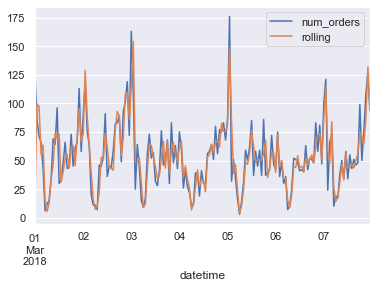

In [38]:
data[:24*7].plot()

## Анализ

*Данные представлены за 6 месяцев, с марта по конец августа*

*Разложим временной ряд на тренд, сезонность и остаток*

In [39]:
decompose = seasonal_decompose(data['num_orders'])

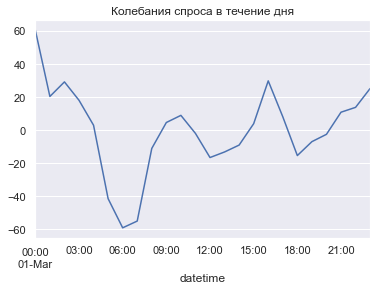

In [40]:
decompose.seasonal[:24].plot()
plt.title('Колебания спроса в течение дня')
plt.show()

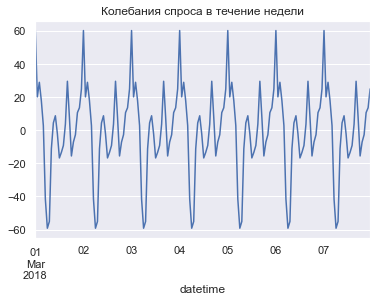

In [41]:
decompose.seasonal[:24*7].plot()
plt.title('Колебания спроса в течение недели')
plt.show()

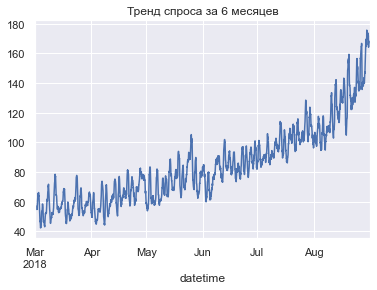

In [42]:
decompose.trend.plot()
plt.title('Тренд спроса за 6 месяцев')
plt.show()

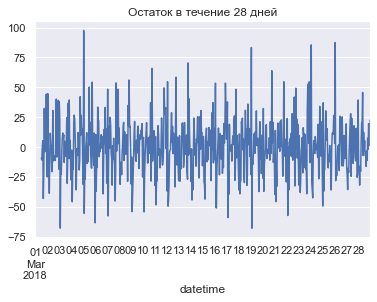

In [43]:
decompose.resid[:24*7*4].plot()
plt.title('Остаток в течение 28 дней')
plt.show()

*Временной ряд показывает, что спрос на такси постоянно растет, также видна сезонность спроса в течение дня и недели. Меньше всего заказов рано утром, когда люди не едут на работу, но и не возвращаются с ночных смен или клубов. Поэтому добавим как новые признаки два столбца с часом и днем недели. Также добавим временное смещение от 1 до 48 часов. Видно, что вечер пятницы наиболее горячие часы.*

In [105]:
data['dayofweek'] = data.index.dayofweek
data['hour'] = data.index.hour
data['rolling'] = data['num_orders'].shift().rolling(3).mean()
for lag in range(1, 169):
    data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
data = data.dropna()

*Проверим, можем ли мы считать, врменной ряд стационарным. Применим  тест Дики-Фуллера. В данном случае гипотезы звучат следующим образом:*

- Нулевая гипотеза предполагает, что процесс нестационарный
- Альтернативная гипотеза, соответственно, говорит об обратном

In [45]:
adf_test = adfuller(data['num_orders'])
print('p-value = ' + str(adf_test[1]))

p-value = 0.03256254040657935


*Значения p меньше 5%, так что примим теорию, что процесс стационарен.*

*Обучим модель. Но сначала подготовим данные*

In [106]:
target = data['num_orders']
feature = data.drop('num_orders',axis=1)

In [107]:
feature_train, feature_test, target_train, target_test = train_test_split(feature, target,shuffle=False,test_size=.2)
feature_valid, feature_test, target_valid, target_test = train_test_split(feature_test, target_test,shuffle=False,test_size=.5)

*Построим автокорреляционную кривую. Из нее видно, что каждые 24 часа возникает пик корреляции, что опять же говорит о периоди 24 часа*

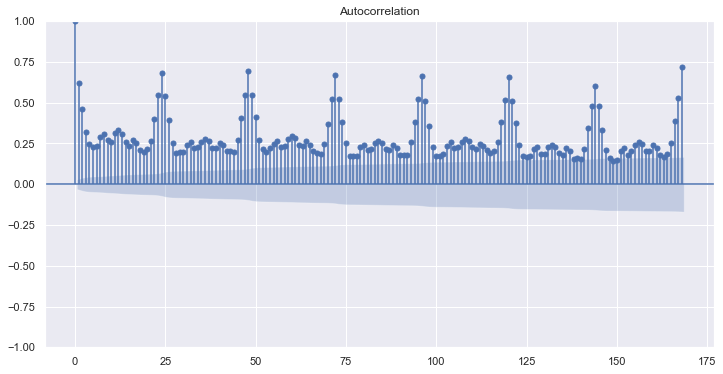

In [48]:
fig, ax1 = plt.subplots(figsize=(12,6))
plot_acf(target, lags=24*7,ax=ax1);

## Обучение и тестирование

*Обучим модель* **SARIMAX**

In [49]:
model = SARIMAX(target_train, 
                order = (0, 0, 0), 
                seasonal_order = (2, 1, 0, 24))
sarimax_fit = model.fit()

In [50]:
predict = sarimax_fit.predict(target_valid.index[0],target_valid.index[-1])

RMSE =  35.179263736980026


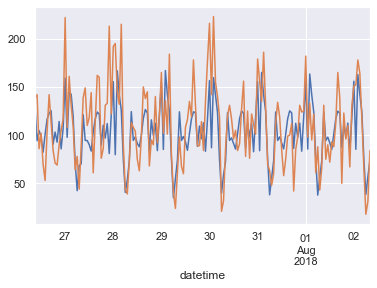

In [53]:
predict[:24*7].plot()
target_valid[:24*7].plot()
print('RMSE = ',np.sqrt(mean_squared_error(target_valid,predict)))

*Обучим* **линейную регрессию**

In [55]:
model_lr = LinearRegression()# < обучите модель >
model_lr.fit(feature_train,target_train)
predict_lr = pd.DataFrame(model_lr.predict(feature_valid),index=target_valid.index)

RMSE =  34.3822167657346


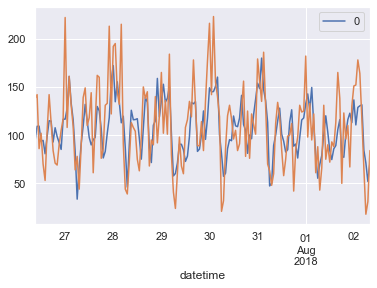

In [56]:
predict_lr[:24*7].plot()
target_valid[:24*7].plot()
print('RMSE = ',np.sqrt(mean_squared_error(target_valid,predict_lr)))

*Обучим* **случайный лес**

In [57]:
%%time
model = RandomForestRegressor()
param_search = {'max_depth' : range(3,12,2),'n_estimators' : (100,200,300)}
tscv = TimeSeriesSplit(n_splits=2)
gsearch = GridSearchCV(estimator=model,
                       cv=tscv,
                       param_grid=param_search)
grid_result = gsearch.fit(feature_train, target_train)
best_params = grid_result.best_params_

CPU times: total: 1min 27s
Wall time: 1min 29s


In [58]:
random_forest = RandomForestRegressor(max_depth=best_params["max_depth"],
                                      n_estimators=best_params["n_estimators"],
                                      random_state=123)

In [59]:
%%time
random_forest.fit(feature_train,target_train)

CPU times: total: 8 s
Wall time: 8.14 s


RandomForestRegressor(max_depth=11, n_estimators=200, random_state=123)

In [60]:
predict_rf = pd.DataFrame(random_forest.predict(feature_valid),index=target_valid.index)

RMSE =  32.64561926439992


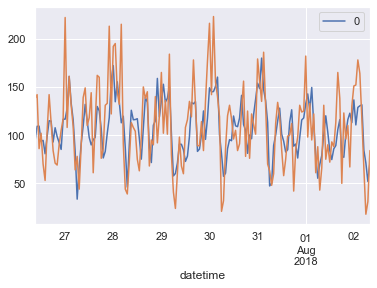

In [61]:
predict_lr[:24*7].plot()
target_valid[:24*7].plot()
print('RMSE = ',np.sqrt(mean_squared_error(target_valid,predict_rf)))

*Обучим* **LGMB регрессор**

In [108]:
%%time
model_lgb = LGBMRegressor(random_state=123, objective='mean_squared_error')
param_search = {'n_estimators' : range(70,300,30),'max_depth' : [-1] + list(range(10,30,5))}
tscv = TimeSeriesSplit(n_splits=2)
gsearch = GridSearchCV(estimator=model_lgb,
                       cv=tscv,
                       param_grid=param_search)
grid_result_lgb = gsearch.fit(feature_train, target_train)
best_params_lgb = grid_result_lgb.best_params_
lgb = LGBMRegressor(n_estimators=best_params["n_estimators"],
                    max_depth=best_params['max_depth'],
                    random_state=123)

CPU times: total: 6min 1s
Wall time: 49.2 s


In [109]:
%%time
lgb.fit(feature_train,target_train)

CPU times: total: 5.78 s
Wall time: 813 ms


LGBMRegressor(max_depth=11, n_estimators=200, random_state=123)

RMSE =  30.423626067624895


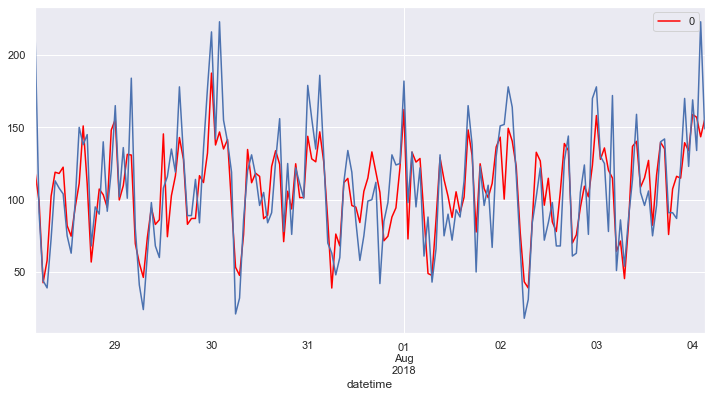

In [110]:
predict_lgb = pd.DataFrame(lgb.predict(feature_valid),index=target_valid.index)
fig, ax1 = plt.subplots(figsize=(12,6))
predict_lgb[:24*7].plot(ax=ax1,color='red')
target_valid[:24*7].plot(ax=ax1)
print('RMSE = ',np.sqrt(mean_squared_error(target_valid,predict_lgb)))

*Модель* **LGBMRegressor** *показала лучший результат RMSE=31, выберем ее и протестируем на осоответсвующей выборке*

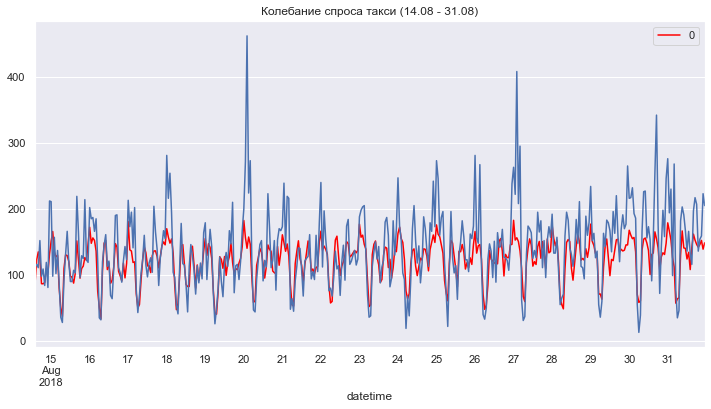

In [111]:
predict_lgb_test = pd.DataFrame(lgb.predict(feature_test),index=target_test.index)
fig, ax1 = plt.subplots(figsize=(12,6))
predict_lgb_test.plot(ax=ax1,color='red')
target_test.plot(ax=ax1)
plt.title('Колебание спроса такси (14.08 - 31.08)')
plt.show()

In [112]:
print('RMSE = ',np.sqrt(mean_squared_error(target_test,predict_lgb_test)))

RMSE =  44.60719546911928


**Вывод**

*В ходе проекта был подготовлен датасет с временным рядом для предсказания спроса такси. Были выбраны четыре регрессеонные модели: SARIMAX, линейная регрессия, случайный лес и lgmb. Лучшей моделю оказалась модель lgmb с RMSE = 44. Модель досататочно точно предсказала колебания временного ряда. Видна периодичность в 24 часа и основные тренды как возрастание спроса к вечеру, спады утром. Главное что не смогла предсказать модель, тестовый ряд имеет пики  20 и 27 августа, что характерно оба понедельники. Они ничем не объясняются, что и стало причиной почему модель их не предсказала.*